# Машинное обучение, ФКН ВШЭ

# Практическое задание 10. Обучение без учителя.

## Общая информация
Дата выдачи: 28.03.2024

Мягкий дедлайн: 15.04.2024 23:59 MSK

Жёсткий дедлайн: 21.04.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи).

Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к географическим и текстовым данным. Также мы подробно остановимся на тематическом моделировании текстов, задаче обучения представлений и в каком-то смысле поработаем с semi-supervised learning.



In [64]:
import pandas as pd
import numpy as np
from scipy.linalg import eigh
from sklearn.base import ClusterMixin
from sklearn.cluster import KMeans
import folium
from itertools import product
from scipy.spatial import distance_matrix
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import colors
from sklearn.cluster import KMeans, DBSCAN
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import LabelSpreading
from sklearn.semi_supervised import SelfTrainingClassifier
from IPython.display import Image

np.random.seed(0xFFFFFFF)

**Задание 0 (1e-100 балла)**. Опишите свои ощущения от домашки по ЕМ-алгоритму (можно картинкой или мемом).

https://youtu.be/4PwDFddpo4c?si=6099wOZ6VItIx-Yx

## Часть 1. Кластеризация автобусных остановок

В этом задании мы сравним разные алгоритмы кластеризации для данных об автобусных остановках Москвы.

**Задание 1.1 (1 балл).** Реализуйте алгоритм спектральной кластеризации, который упоминался на лекции. Для этого разберитесь с кодом шаблона, данного ниже, и допишите недостающую функцию. Напомним, что для графа с матрицей смежности $W = \{w_{ij}\}_{i, j = 1 \dots \ell}$ лапласиан определяется как:

$$
L = D - W,
$$

где $D = \text{diag}(d_1, ..., d_{\ell}), d_i = \sum_{j=1}^{\ell} w_{ij}$.

In [5]:
class GraphClustering(ClusterMixin):
    def __init__(self, n_clusters=8, n_components=None, **kwargs):
        '''
        Spectral clustering algorithm
        param n_clusters: number of clusters to form
        param n_components: number of eigenvectors to use
        '''

        if n_components is None:
            n_components = n_clusters

        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, **kwargs)

    def fit_predict(self, X, y=None):
        '''
        Perform spectral clustering from graph adjacency matrix
        and return vertex labels.
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, ) - vertex labels
        '''

        eigenvectors = self._generate_eigenvectors(X)
        labels = self.kmeans.fit_predict(eigenvectors[:, 1:])
        return labels

    def _generate_eigenvectors(self, X):
        '''
        Compute eigenvectors for spectral clustering
        param X: (n_samples, n_samples) - graph adjacency matrix
        return: (n_samples, n_components) - eigenvectors
        '''
        D = np.diag(np.sum(X, axis=1))
        L = D - X
        eigenvalues, eigenvectors = np.linalg.eigh(L)
        return eigenvectors[:, :self.n_components]

Перед тем, как переходить к следующему заданию, протестируйте свое решение.

In [ ]:
n_blocks, n_vertices = 10, 1000
block_vertices = n_vertices // n_blocks

X = np.zeros((n_vertices, n_vertices))
for i in range(0, n_vertices, block_vertices):
    X[i:i + block_vertices, i:i + block_vertices] = np.sqrt(i + 1)

graph_clustering = GraphClustering(n_clusters=n_blocks)
labels = graph_clustering.fit_predict(X)

true_labels = np.zeros(n_vertices, dtype=np.int32)
for i in range(0, n_vertices, block_vertices):
    true_labels[i:i + block_vertices] = labels[i]

assert labels.shape == (n_vertices, )
assert np.all(np.bincount(labels) == np.full(n_blocks, block_vertices))
assert np.all(labels == true_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Теперь можем приступить к работе с реальными данными. Скачайте файл с данными об остановках общественного транспорта **в формате .xlsx** по [ссылке](https://data.mos.ru/opendata/download/60464/1/201) (так гарантированно не возникнет проблем с парсингом файла) и загрузите таблицу в ноутбук. Если вдруг сайт Правительства Москвы сойдет с ума, то возьмите какую-нибудь версию данных [отсюда](https://data.mos.ru/opendata/7704786030-city-surface-public-transport-stops). Для удобства визуализации мы будем работать только с остановками в ЦАО.

In [ ]:
data = pd.read_excel('/Users/vera/Downloads/City surface public transport stops.xlsx')
data = data[data.AdmArea_en == "Czentral`ny'j administrativny'j okrug"]
data = data.reset_index()
data.head()

Воспользуемся библиотекой `folium` для визуализации данных.

In [ ]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for id, row in data.iterrows():
    folium.Circle([row.Latitude_WGS84_en, row.Longitude_WGS84_en],
                  radius=10).add_to(map)
map

**Задание 1.2 (1 балл).** Попробуем построить граф, в котором вершинами будут остановки. Как вы уже могли заметить, для каждой остановки указаны номера маршрутов, проходящих через неё. Логично соединить ребрами соседние остановки каждого маршрута. Однако мы не знаем, в каком порядке автобусы объезжают остановки. Но мы можем применить эвристический алгоритм, который восстановит нам порядок маршрутов:

* Для каждого маршрута выделим список всех остановок, через которые он проходит.
* Выберем начальную остановку маршрута как точку, наиболее удаленную от всех остальных остановок этого маршрута.
* Каждую следующую точку маршрута будем выбирать как самую близкую из оставшихся точек (не включенных в маршрут ранее).

Фактически, у нас получается жадное решение задачи коммивояжера. Когда мы отсортировали маршруты, можем построить по ним граф. Будем строить его по таким правилам:

* Между двумя остановками будет ребро, если они являются соседними хотя бы на одном маршруте. Вес ребра равен числу маршрутов, на которых остановки являются соседними.
* В графе не будет петель (то есть у матрицы смежности будет нулевая диагональ).

Реализуйте предложенный способ построения графа. Для этого рекомендуется воспользоваться шаблонами, приведенными ниже.

In [6]:
def get_routes(data):
    '''
    Accumulate routes from raw data
    param data: pd.DataFrame - public transport stops data
    return: dict - unsorted stops ids for each route,
                   e.g. routes['A1'] = [356, 641, 190]
    '''
    stops = {}
    for route_numbers, stop_id in zip(data['RouteNumbers_en'], data['ID_en']):
        for route in route_numbers.split():
            if route.endswith(','):
                route = route[:-1]
            stops.setdefault(route, []).append(stop_id)

    return stops

def sort_routes(data, routes):
    '''
    Sort routes according to the proposed algorithm
    param data: pd.DataFrame - public transport stops data
    param routes: dict - unsorted stops ids for each route
    return: dict - sorted stops ids for each route
    '''
    stop_to_coords = {row['ID_en']: np.array([row['Longitude_WGS84_en'], row['Latitude_WGS84_en']]) for index, row in data.iterrows()}
    sorted_routes = {}
    for key, stops in routes.items():
        coords = np.array([stop_to_coords[stop] for stop in stops])
        dist_matr = np.sum((coords[:, np.newaxis, :] - coords[np.newaxis, :, :]) ** 2, axis=2)
        min_dist = np.min(dist_matr + np.diag([np.inf]*len(stops)), axis=0)
        order = [np.argmax(min_dist)]
        for _ in range(len(stops) - 1):
            last = order[-1]
            dist_matr[:, last] = np.inf
            order.append(np.argmin(dist_matr[last, :]))
        act_order = [data[data['ID_en'] == stops[i]].index[0] for i in order]
        sorted_routes[key] = act_order
    return sorted_routes


def get_adjacency_matrix(data, sorted_routes):
    '''
    Compute adjacency matrix for sorted routes
    param data: pd.DataFrame - public transport stops data
    param sorted_routes: dict - sorted stops ids for each route
    return: (n_samples, n_samples) - graph adjacency matrix
    '''
    idx_map = {stop_id: i for i, stop_id in enumerate(data.index)}
    adjacency_matrix = np.zeros((data.shape[0], data.shape[0]))
    for route in sorted_routes.values():
        indices = [idx_map[stop] for stop in route]
        for i in range(len(indices) - 1):
            from_idx = indices[i]
            to_idx = indices[i + 1]
            adjacency_matrix[from_idx, to_idx] += 1
            adjacency_matrix[to_idx, from_idx] += 1
    return adjacency_matrix

In [ ]:
routes = get_routes(data)
sorted_routes = sort_routes(data, routes)
adjacency_matrix = get_adjacency_matrix(data, sorted_routes)

Проверим, что маршруты получились адекватными. Для этого нарисуем их на карте.

In [ ]:
map = folium.Map([55.75215, 37.61819], zoom_start=12)
for route_id in np.random.choice(list(sorted_routes.keys()), size=5):
    coords = data.loc[
        sorted_routes[route_id],
        ['Latitude_WGS84_en', 'Longitude_WGS84_en']
    ].values.tolist()
    folium.vector_layers.PolyLine(coords).add_to(map)

map

**Задание 1.3 (0 баллов)**. Реализуйте функцию `draw_clustered_map`, которая рисует карту центра Москвы с кластерами остановок, раскрашенными в разные цвета.

Идея и код взяты отсюда, не ругайте, оно 0 баллов весит...: https://www.kaggle.com/code/lucaspcarlini/clustering-and-visualisation-using-folium-maps/notebook

In [ ]:
def draw_clustered_map(data, labels):
    '''
    Create map with colored clusters on a Folium map.
    param data: pd.DataFrame - public transport stops data
    param labels: (n_samples, ) - cluster labels for each stop
    return: folium.Map - map with colored clusters
    '''
    map_clusters = folium.Map(location=[55.7510, 37.6176], zoom_start = 11.5)
    unique_labels = np.unique(labels)
    colors_array = cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    rainbow = [colors.rgb2hex(color) for color in colors_array]
    for lat, lng, cluster in zip(data['Latitude_WGS84_en'], data['Longitude_WGS84_en'], labels):
        folium.vector_layers.CircleMarker(
            location = [lat, lng],
            radius = 5,
            color = rainbow[cluster],
            fill = True,
            fill_color = rainbow[cluster],
            fill_opacity = 0.9
        ).add_to(map_clusters)

    return map_clusters

In [ ]:
draw_clustered_map(data, labels)

**Задание 1.4 (1.5 балла)**. Примените алгоритмы кластеризации K-Means и DBSCAN из `sklearn` на координатах остановок, а также свою реализацию спектральной кластеризации на построенной выше матрице смежности. Визуализируйте результат кластеризации с помощью функции `draw_clustered_map`. Подберите параметры алгоритмов (`n_clusters` у K-Means, `eps` у DBSCAN, `n_clusters` и `n_components` у спектральной кластеризации) так, чтобы получить наиболее характерный для этих алгоритмов результат кластеризации (можете поэкспериментировать и оставить в ноутбуке картинки только для итоговых значений параметров, также обратите внимание на баланс объектов в кластерах). Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [ ]:
X = data[['Latitude_WGS84_en', 'Longitude_WGS84_en']]
kmeans = KMeans(n_clusters = 15, random_state = 42).fit(X).predict(X)
dbscan = DBSCAN(0.01).fit(X).labels_
spectr = GraphClustering(200, 70).fit_predict(adjacency_matrix)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
draw_clustered_map(data, kmeans)

In [ ]:
draw_clustered_map(data, dbscan)

In [ ]:
draw_clustered_map(data, spectr)

Проинтерпретируйте полученные результаты. Чем отличаются разбиения на кластеры, получаемые разными алгоритмами? Какие плюсы и минусы есть у каждого алгоритма? Какой алгоритм кажется вам наиболее подходящим для кластеризации остановок?

**Ответ:** 1. k-means. Он стремится минимизировать сумму квадратов расстояний до центров кластеров, из-за чего получаются кластеры какой-то геометрической формы. Он быстро обучается, но плохо справляется с кластерами сложной формы, так что для обработки маршрутов этот алгоритм н еочень подходит, потому что там нужно учитывать пути следования, а не только географическую близость.
dbscan. Создает один большой кластер, а также нескольк омаленьких кластеров. тут разница в плотностях кластеров существенная, так что этот метод работает плохо, поскольку есть "разреженные" кластеры остановок.
Спектральная кластеризация. Подходит лучше всех, поскольку хорошо работает с данными, где важна взаимосвязь между точками.

## Часть 2. Тематическое моделирование текстов

В этой части мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [8]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

category filename                              title  \
1289       politics  394.txt  Economy focus for election battle   
1872           tech  049.txt            Domain system scam fear   
1044       politics  149.txt   Blair returns from peace mission   
654   entertainment  145.txt   Sir Paul rocks Super Bowl crowds   
134        business  135.txt   Feta cheese battle reaches court   

                                                content  
1289   Britain's economic future will be at the hear...  
1872   A system to make it easier to create website ...  
1044   Prime Minister Tony Blair has arrived back fr...  
654    Sir Paul McCartney wowed fans with a live min...  
134    A row over whether only Greece should be allo...

Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой части мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [10]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [12]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [22]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

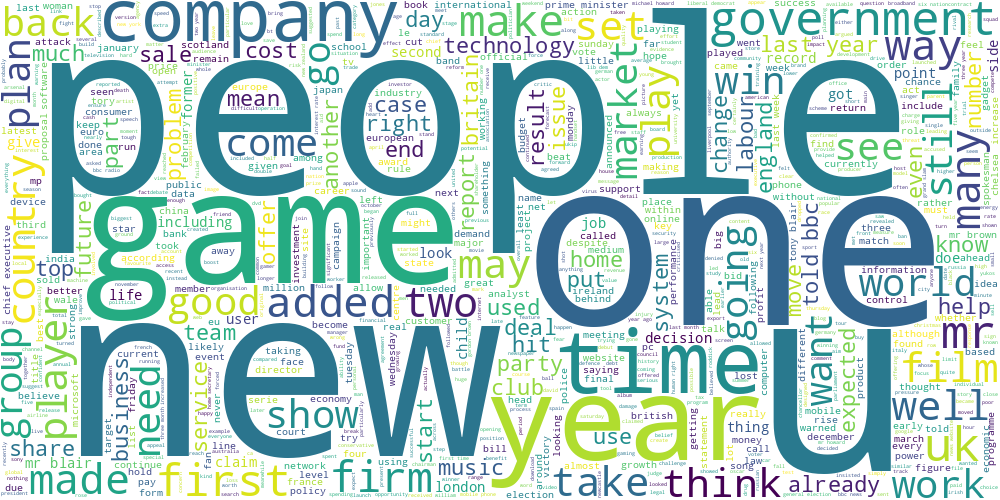

In [ ]:
draw_wordcloud(data.text)

**Задание 2.1 (1 балл).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении tf-idf векторайзера рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [16]:
tfidf = TfidfVectorizer()

In [ ]:
kmeans = KMeans(n_clusters = 10, random_state = 42)
preds_kmeans = kmeans.fit_predict(tfidf.fit_transform(data['text']))

# Бизнес

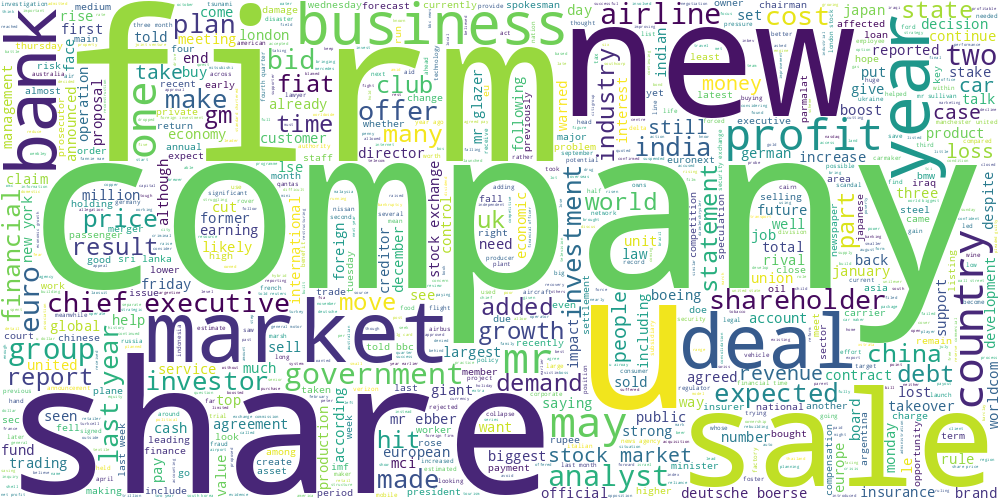

In [ ]:
draw_wordcloud(data['text'][preds_kmeans == 0])

# Политика

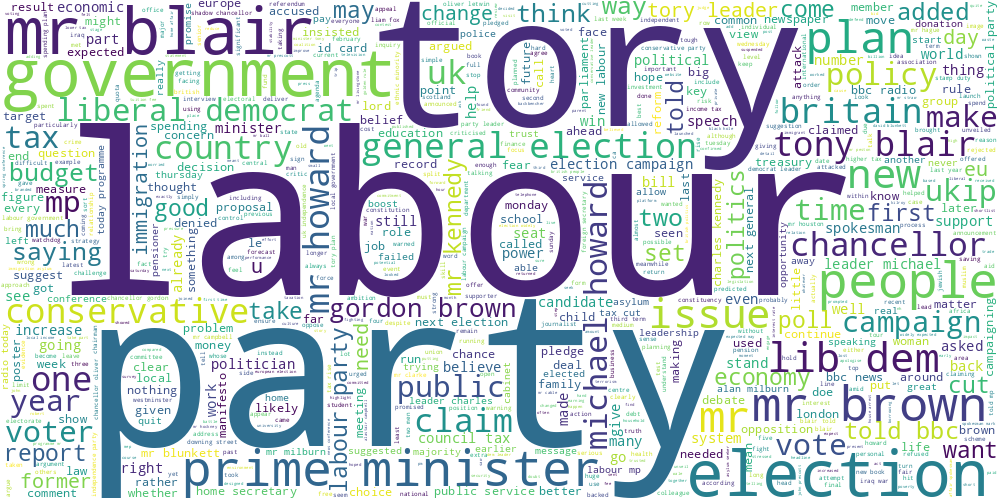

In [ ]:
draw_wordcloud(data['text'][preds_kmeans == 1])

# Развлечения

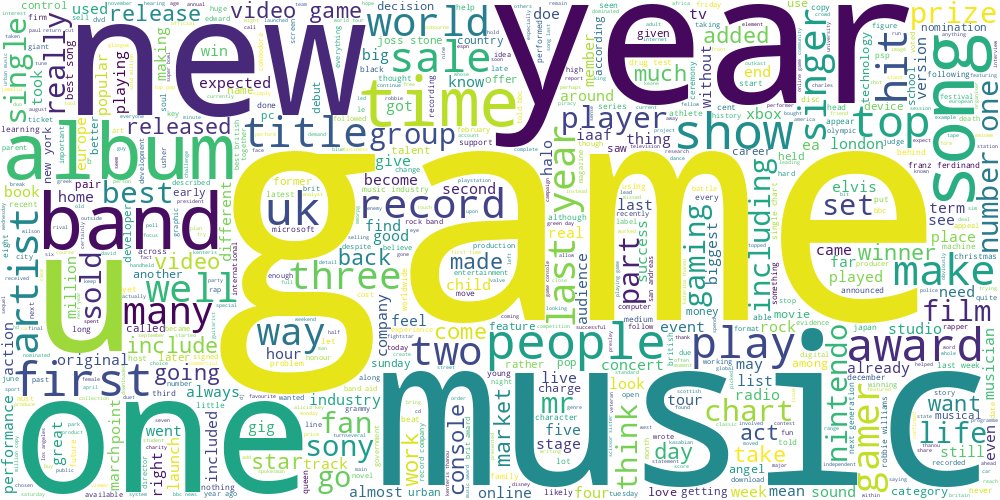

In [ ]:
draw_wordcloud(data['text'][preds_kmeans == 5])

Да, темы получились интерпретируемые.

**Задание 2.2 (0.5 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [19]:
tfidf = TfidfVectorizer()
tfidf.fit_transform(data['text'])

<2225x24207 sparse matrix of type '<class 'numpy.float64'>'
	with 316338 stored elements in Compressed Sparse Row format>

In [23]:
lst = []
for i in range(8):
    dom = kmeans.cluster_centers_[i].argmax()
    mask = np.zeros(kmeans.cluster_centers_[i].shape[0])
    mask[dom] = kmeans.cluster_centers_[i][dom]
    lst.append(tfidf.inverse_transform(mask)[0][0])
print(lst)

['mobile', 'economy', 'user', 'game', 'olympic', 'mr', 'film', 'mr']


Да, судя по вордклаудам, которые мы построили, центры совпадают с темами.

**Задание 2.3 (1.5 балла).** В первой части мы сравнили три разных алгоритма кластеризации на географических данных. Проделаем то же самое для текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов K-Means, DBSCAN и спектральной кластеризации (на этот раз воспользуйтесь реализацией из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [65]:
tfidf = TfidfVectorizer()
X_tf = tfidf.fit_transform(data['text'])

In [67]:
kmeans = KMeans(n_clusters = 8)
kmeans.fit(X_tf)
preds_kmeans = kmeans.predict(X_tf)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [68]:
dbscan = DBSCAN(eps = 0.5)
dbscan.fit(X_tf)
preds_dbscan = dbscan.labels_

In [69]:
spectr = SpectralClustering()
preds_spectr = spectr.fit_predict(X_tf)

In [ ]:
tsne = TSNE(init = 'random')
X_tsne = tsne.fit_transform(X_tf)

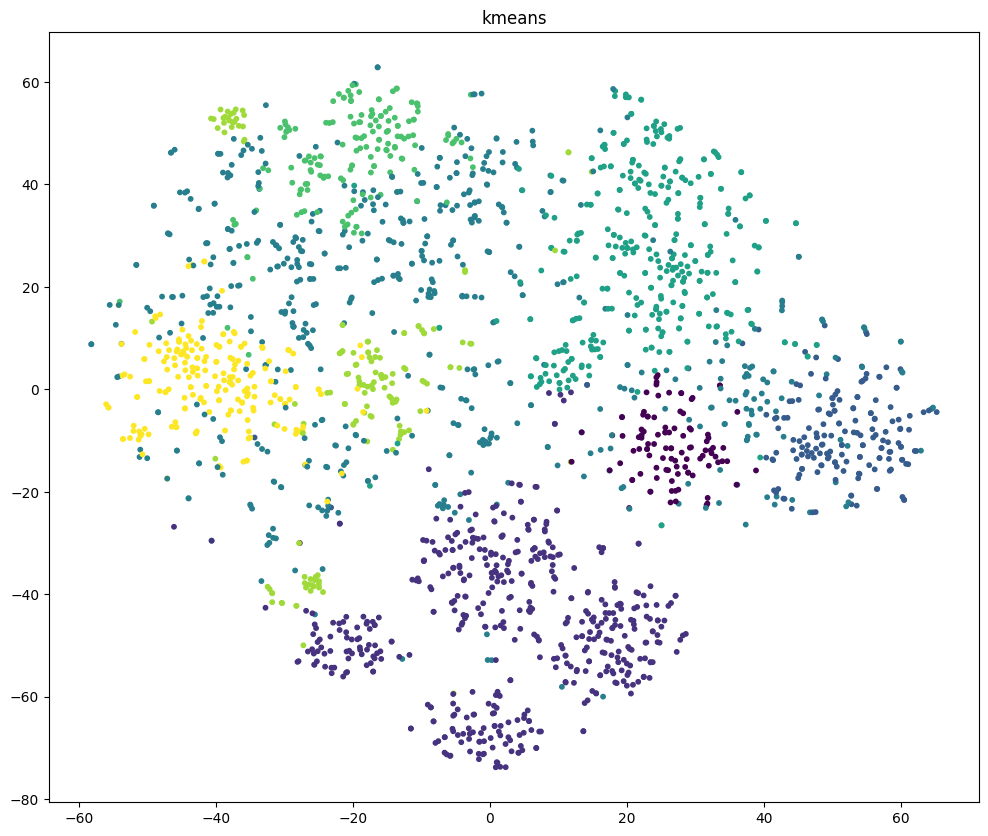

In [74]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=preds_kmeans, s=10)
plt.title('kmeans')
plt.show()

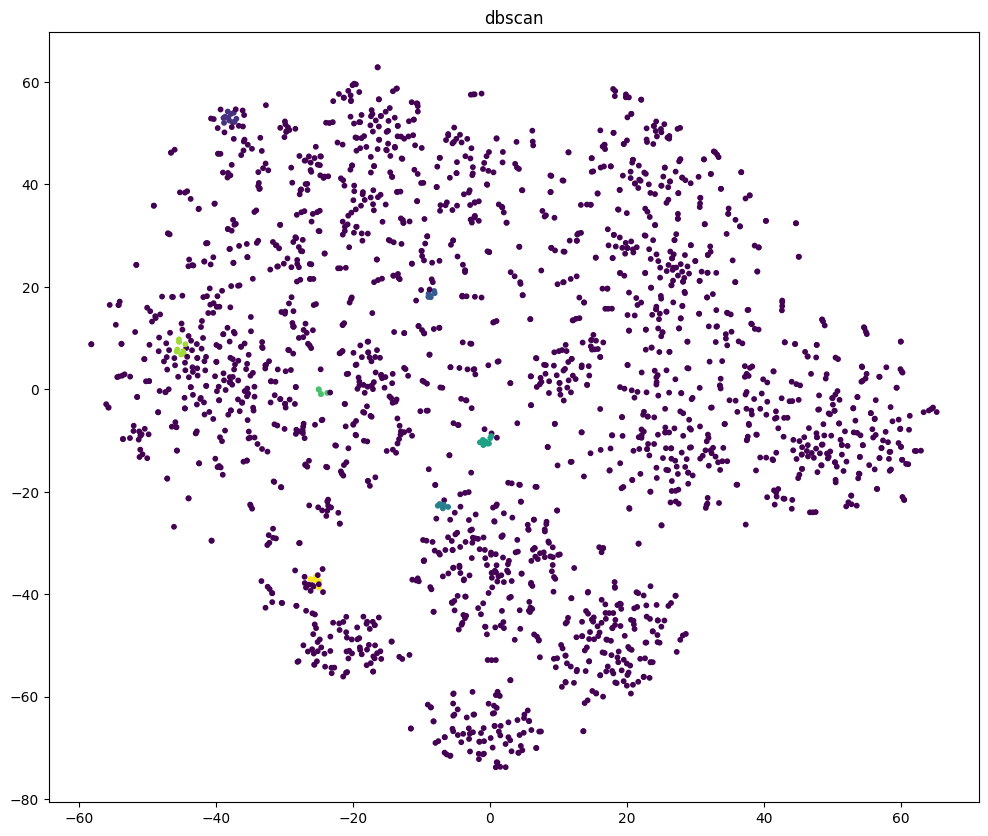

In [76]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=preds_dbscan, s=10)
plt.title('dbscan')
plt.show()

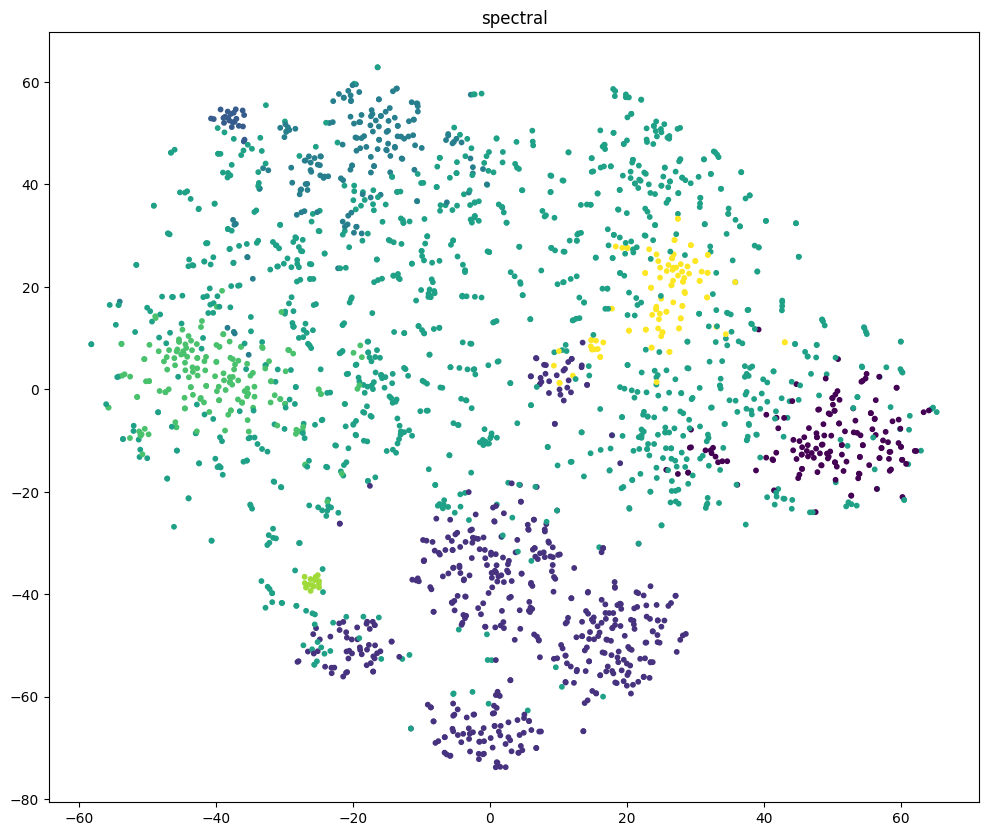

In [82]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=preds_spectr, s = 10)
plt.title('spectral')
plt.show()

Прокомментируйте получившиеся результаты. Какой баланс кластеров получился у разных методов? Соотносятся ли визуализации для текстов с визуализациями для географических данных?

**Ответ:** kmeans более равномерно и четко разбил кластеры, четко видны различия. То же самое мы и получили для геоданных, только здесь такой результат более релевантен, потому что 'маршруты' нам больше учитывать не нужно))

Спектральная кластеризация тоже хорошо разделила классы, кажется, они чуть более сложно расположены относительно друг друга, чем в kmeans. Кажется, кластериация релевантна. На геоданных она тоже была таковой, только кластреры были сильно перемешаны.

DBSCAN показал довольно плотную кластеризацию, большая часть точек сгруппирована в единственный кластер, и есть выбросы, очень похоже на геоданные.

**Задание 2.4 (1.5 балла).** Обучите модель латентного размещения Дирихле. Не забудьте, что она работает с мешком слов, а не с tf-idf признаками. Придумайте, как превратить распределение тем для текста в номер его кластера. Возьмите параметр `n_components` в 2-3 раза больше, чем число кластеров для K-Means. Получились ли темы более узкими от такого нововведения? Постройте облака тегов для нескольких наиболее удачных тем.

**Ответ:**

In [20]:
model1 = CountVectorizer()
X_cnt = model1.fit_transform(data['text'])

model2 = LatentDirichletAllocation(n_components = 20, random_state = 42)
preds = np.argmax(model2.fit_transform(X_cnt), axis = 1)


# Всемирные достижения? Известные личности? Певцы?

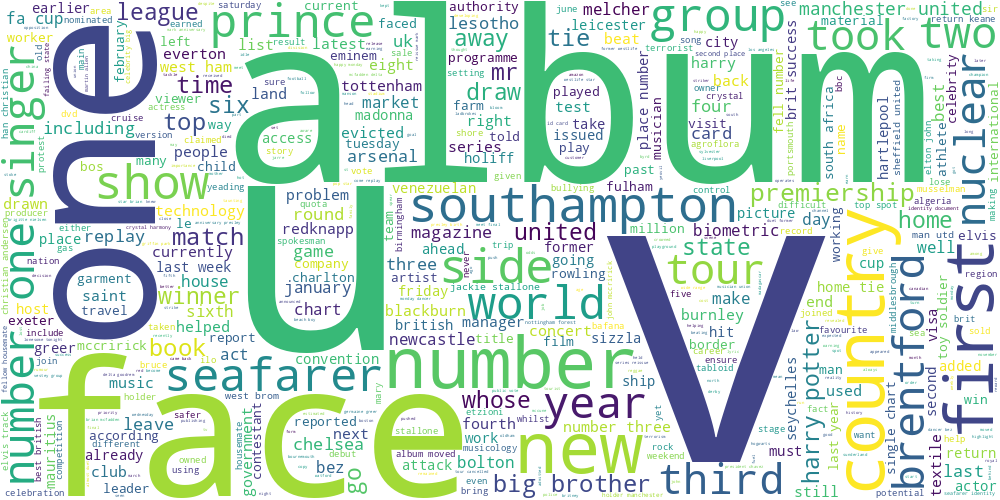

In [23]:
draw_wordcloud(data['text'][preds == 0])

# Развлечения? Конкурсы?

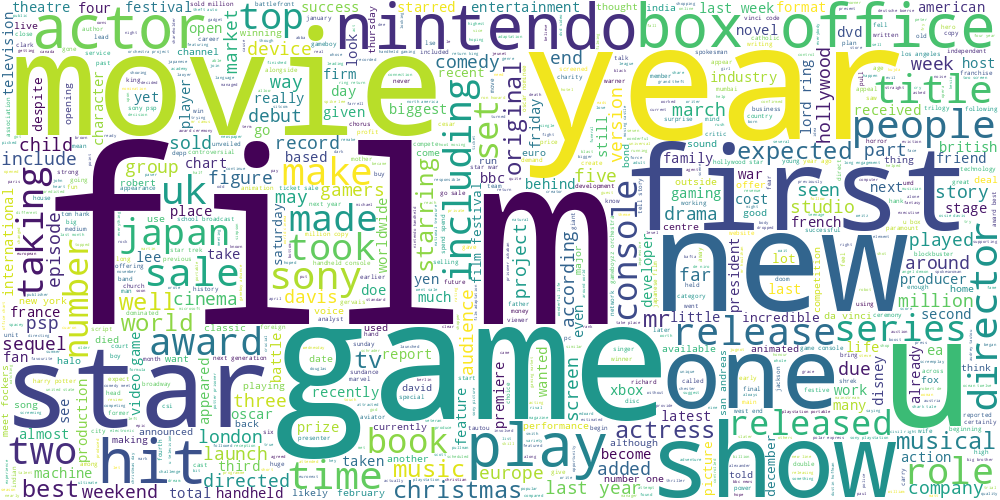

In [24]:
draw_wordcloud(data['text'][preds == 1])

# Победы? Соревнования?

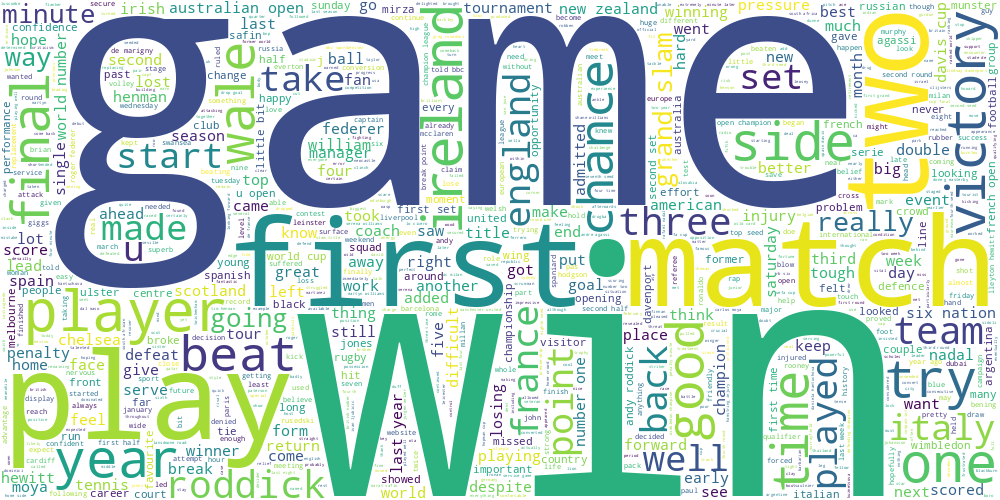

In [25]:
draw_wordcloud(data['text'][preds == 5])

Да, темы получились более узкими и менее интерпретируемыми, каждый кластер фокусируется на одной маленькой теме.

## Часть 3. Transfer learning для задачи классификации текстов

**Задание 3.1 (0.5 балла).** Вспомним, что у нас есть разметка для тематик статей. Попробуем обучить классификатор поверх unsupervised-представлений для текстов. Рассмотрите три модели:

* Логистическая регрессия на tf-idf признаках
* K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров
* Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

Разделите выборку на обучающую и тестовую, замерьте accuracy на обоих выборках для всех трех моделей. Параметры всех моделей возьмите равными значениям по умолчанию.

In [28]:
y = data.replace(list(data['category'].unique()), np.arange(5))['category']
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Логистическая регрессия на tf-idf признаках

In [29]:
tfidf_3 = TfidfVectorizer()
lr_3 = LogisticRegression()

X_train = tfidf_3.fit_transform(X_train)
X_test = tfidf_3.transform(X_test)

lr_3.fit(X_train, y_train)

accuracy_score(lr_3.predict(X_test), y_test)

0.9730538922155688

# K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров

In [30]:
kmeans = KMeans(n_clusters=8)
lrkmeans = LogisticRegression()

X_train = kmeans.fit_transform(X_train)
X_test = kmeans.transform(X_test)

lrkmeans  = LogisticRegression()
lrkmeans.fit(X_train, y_train)
accuracy_score(lrkmeans.predict(X_test), y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.8383233532934131

# Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

In [32]:
mod = CountVectorizer(decode_error = 'ignore')
X = mod.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

lda = LatentDirichletAllocation(n_components = 10, random_state = 42)

lrd = LogisticRegression()
lrd.fit(lda.fit_transform(X_train), lda.transform(X_test))
accuracy_score(lrd.predict(lda.transform(X_test)), y_test)

0.9341317365269461

У какой модели получилось лучшее качество? С чем это связано?

**Ответ:** Логистическая регрессия на tf-idf признаках дает лучшее качество. Это может быть связано с тем, что TF-IDF хорошо выделяет ключевые слова для каждой темы, и они могут напрямую указывать на тему статьи. Плюс, tf-idf содает разреженные признаки, так что такие данные очень легко обрабатывать.

**Задание 3.2 (1.5 балла).** Теперь просимулируем ситуацию слабой разметки, которая часто встречается в реальных данных. Разделим обучающую выборку в пропорции 5:65:30. Будем называть части, соответственно, размеченный трейн, неразмеченный трейн и валидация.

Все unsupervised-алгоритмы (векторайзеры и алгоритмы кластеризации) запускайте на всем трейне целиком (размеченном и неразмеченном, суммарно 70%), а итоговый классификатор обучайте только на размеченном трейне (5%). Подберите гиперпараметры моделей по качеству на валидации (30%), а затем оцените качество на тестовой выборке (которая осталась от прошлого задания). Не скромничайте при подборе числа кластеров, сейчас нас интересует не интерпретируемое разбиение выборки, а итоговое качество классификации.

In [35]:
y = data.replace(list(data['category'].unique()), np.arange(5))['category']
X = data['text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val, = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)
X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size = 5 / (5 + 65), random_state = 42)

In [36]:
tfidf = TfidfVectorizer()

In [37]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_labeled_tfidf = tfidf.transform(X_labeled)
X_test_tfidf = tfidf.transform(X_test)

# Логистическая регрессия на tf-idf признаках

In [40]:
lr = LogisticRegression()
lr.fit(X_labeled_tfidf, y_labeled)
accuracy_score(lr.predict(X_val_tfidf), y_val)

0.655982905982906

# K-Means на tf-idf признаках + логистическая регрессия на расстояниях до центров кластеров

In [42]:
accs = []
grid = list(range(25, 151, 25))

for n_clusters in grid:
    kmeans = KMeans(n_clusters=n_clusters)
    lr = LogisticRegression()
    lr.fit(kmeans.transform(X_labeled_tfidf), y_labeled)
    accs.append(accuracy_score(lr.predict(kmeans.transform(X_val_tfidf)), y_val))

kmeans = KMeans(n_clusters = grid[np.array(accs).argmin()])
lr = LogisticRegression()
lr.fit(kmeans.transform(X_labeled_tfidf), y_labeled)
accuracy_score(lr.predict(kmeans.transform(X_test_tfidf)), y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules

0.27694610778443113

# Латентное размещение Дирихле + логистическая регрессия на вероятностях тем

In [43]:
count = CountVectorizer(decode_error= 'ignore')

X1 = count.fit_transform(data['text'])

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size = 0.3, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)
X_unlabeled, X_labeled, y_unlabeled, y_labeled = train_test_split(X_train, y_train, test_size = 5 / 70, random_state = 42)

In [46]:
accs = []
for n_components in grid:
    lda = LatentDirichletAllocation(n_components = 10, random_state = 42)
    probs = lda.fit_transform(X_train)
    lr = LogisticRegression()
    lr.fit(lda.transform(X_labeled), y_labeled)
    accs.append(accuracy_score(lr.predict(lda.transform(X_val)), y_val))

lda = LatentDirichletAllocation(n_components = grid[np.array(acc).argmin()], random_state = 42)
probs = lda.fit_transform(X_train)
lr = LogisticRegression()
lr.fit(lda.transform(X_labeled), y_labeled)
accuracy_score(lr.predict(lda.transform(X_test)), y_test)

0.7844311377245509

Как изменились результаты по сравнению с обучением на полной разметке? Сделайте выводы.

**Ответ:** Качество сильно упало у всех метдов, потому что мы используем лишь малую часть всей выборки. При этом теперь лучше всех работает последний метод.

## Бонус

**Задание 4 (1 балл)**. Разберитесь с semi-supervised методами, которые реализованы в `sklearn` и примените их к заданию 3.2. Получилось ли добиться лучшего качества? Сделайте выводы.

In [49]:
X = data['text']
y = data.replace(list(data['category'].unique()), np.arange(5))['category']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [51]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [52]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [56]:
model1 = SelfTrainingClassifier(LogisticRegression())
model1.fit(X_train, y_train)
accuracy_score(model1.predict(X_test), y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_self_training.py:212: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)


0.9730538922155688

In [53]:
model1 = LabelPropagation()
model1.fit(X_train, y_train)
accuracy_score(model1.predict(X_test), y_test)

0.9236526946107785

In [54]:
model1 = LabelSpreading()
model1.fit(X_train, y_train)
accuracy_score(model1.predict(X_test), y_test)

0.9251497005988024

Да, лучшего качества добиться удалось, SelfTrainingClassifier дает очень хорошее качество.

# LabelPropagation

**Задание 5 (1 балл)**. На занятиях мы обсуждали, что метрика [BCubed](https://www.researchgate.net/profile/Julio-Gonzalo-2/publication/225548032_Amigo_E_Gonzalo_J_Artiles_J_et_alA_comparison_of_extrinsic_clustering_evaluation_metrics_based_on_formal_constraints_Inform_Retriev_12461-486/links/0c96052138dbb99740000000/Amigo-E-Gonzalo-J-Artiles-J-et-alA-comparison-of-extrinsic-clustering-evaluation-metrics-based-on-formal-constraints-Inform-Retriev-12461-486.pdf) хорошо подходит для сравнения алгоритмов кластеризации, если нам известно настоящее разделение на кластеры (gold standard). Реализуйте подсчет метрики BCubed и сравните несколько алгоритмов кластеризации на текстовых данных из основного задания. В качестве gold standard используйте разметку category.

In [57]:
class BCubed:
    def precision(self, y_pred, y_true):
        cum = 0
        for i, label in enumerate(y_pred):
            matching_elements = y_true[y_pred == label]
            cum += np.sum(matching_elements == y_true[i]) / len(matching_elements)
        return cum / len(y_pred)

    def recall(self, y_pred, y_true):
        cum = 0
        for i, label in enumerate(y_true):
            matching_elements = y_pred[y_true == label]
            cum += np.sum(matching_elements == y_pred[i]) / len(matching_elements)
        return cum / len(y_pred)

    def f_score(self, y_pred, y_true):
        precision_score = self.precision(y_pred, y_true)
        recall_score = self.recall(y_pred, y_true)
        if (precision_score + recall_score) == 0:
            return 0
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [78]:
metr = BCubed()
print(f'Precision:{metr.precision(preds_kmeans, np.array(y))}, recall:{metr.recall(preds_kmeans, np.array(y))}, f_score:{metr.f_score(preds_kmeans, np.array(y))}')

Precision:0.7663112465392796, recall:0.5796745918479481, f_score:0.6600532433512183


In [79]:
metr = BCubed()
print(f'Precision:{metr.precision(preds_dbscan, np.array(y))}, recall:{metr.recall(preds_dbscan, np.array(y))}, f_score:{metr.f_score(preds_dbscan, np.array(y))}')

Precision:0.21960604416892102, recall:0.9564461169308132, f_score:0.3571973338384755


In [80]:
metr = BCubed()
print(f'Precision:{metr.precision(preds_spectr, np.array(y))}, recall:{metr.recall(preds_spectr, np.array(y))}, f_score:{metr.f_score(preds_spectr, np.array(y))}')

Precision:0.5726504393173298, recall:0.5655169888618543, f_score:0.5690613596827883


Лучшие precision и f-меру показал kmeans, recall - dbscan.

**Задание 7 (1 балл)**. Наконец, ставший ежегодной традицией социализационный бонус. Мы поощряем не только предметное, но и духовное развитие. Поэтому, чтобы заработать балл за это задание, сходите на какую-нибудь выставку или в музей, напишите небольшой отчетик о ваших впечатлениях и добавьте фотопруфы в ноутбук при сдаче. Можете объединиться с одногруппниками/однокурсниками, а также пригласить ассистентов/преподавателей, они тоже будут рады выбраться куда-нибудь. Для вдохновения приведем ссылку на актуальные выставки [новой](https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab) и [старой Третьяковки](https://www.youtube.com/watch?v=xm3YgoEiEDc) (но совсем не обязательно посещать именно их).

Удивительно совпало, но как раз в момент выдачи этой домашки мы с моей подругой Ксюшей еще были в Сеуле, куда мы поехали на сессионную неделю. Мы сходили в Дворец Кёнбоккун. Это главный дворец одной из династии в Корее, который был практически полностью разрушен во время японской оккупации, но после был восстановлен. Там было прикольно! и все ходили в национальных костюмах! Но мы попали под дождь((

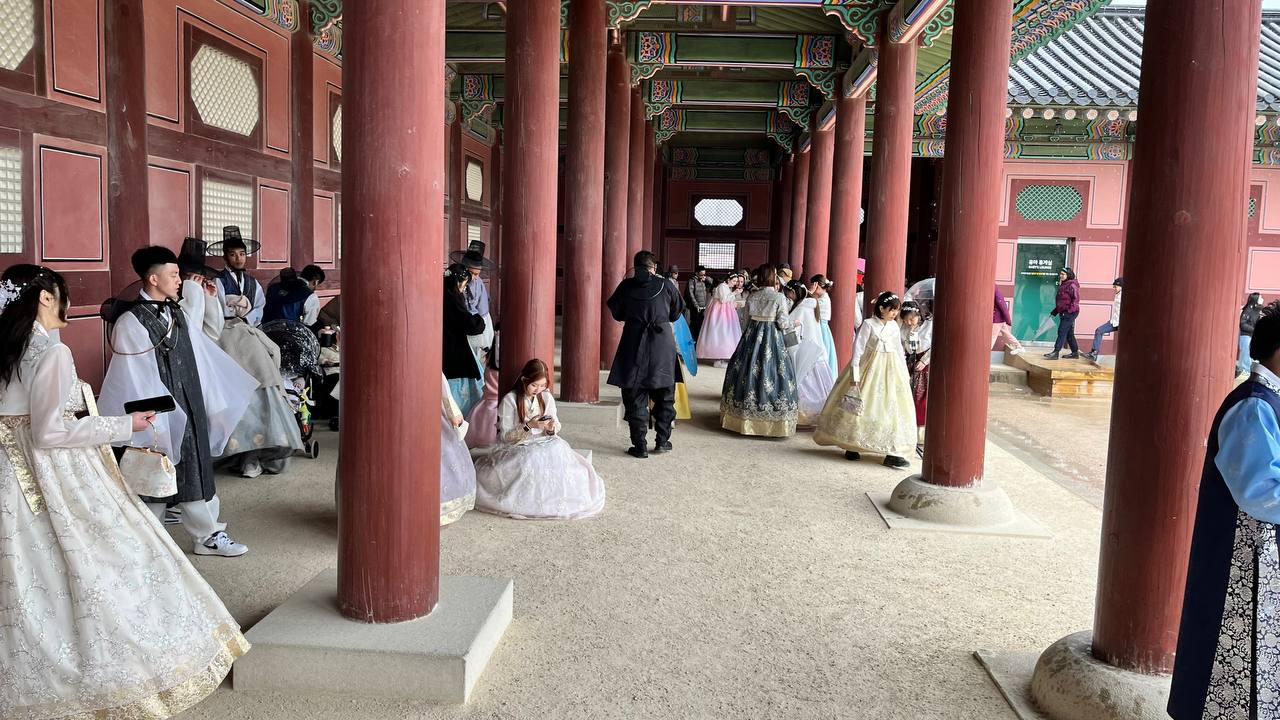

In [61]:
Image("/content/koree1.jpg")

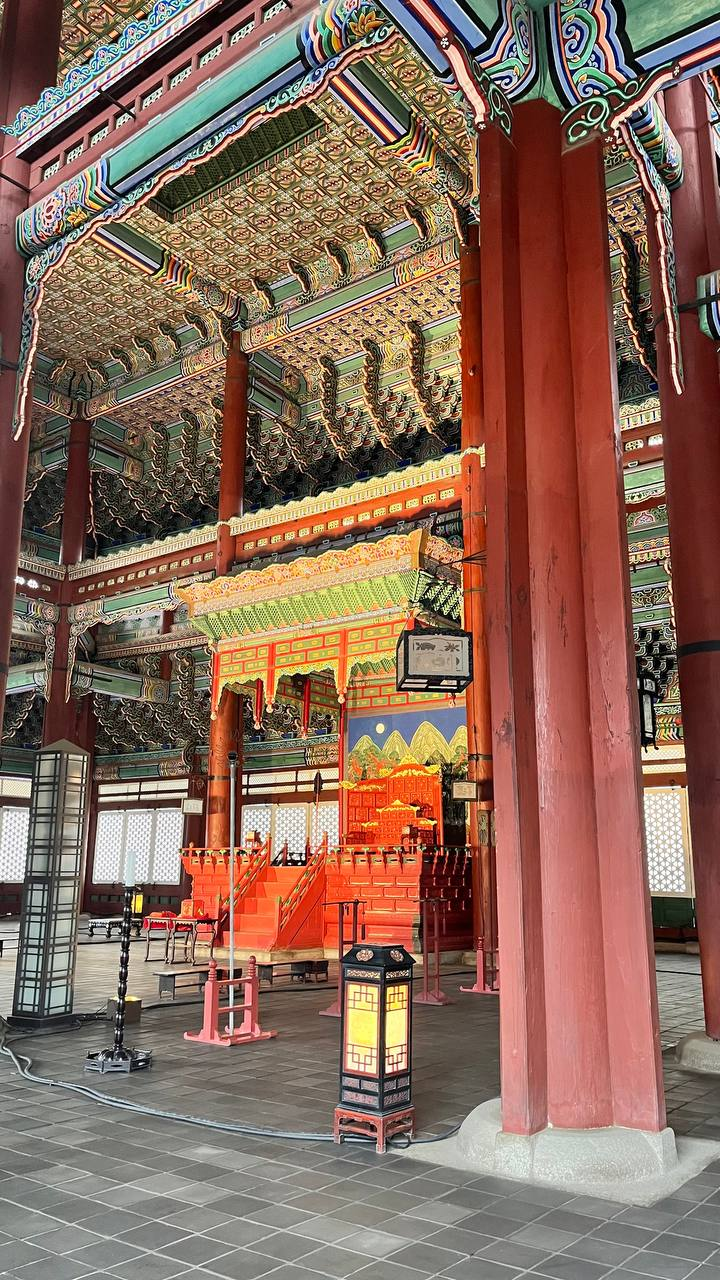

In [62]:
Image("/content/koree2.jpg")

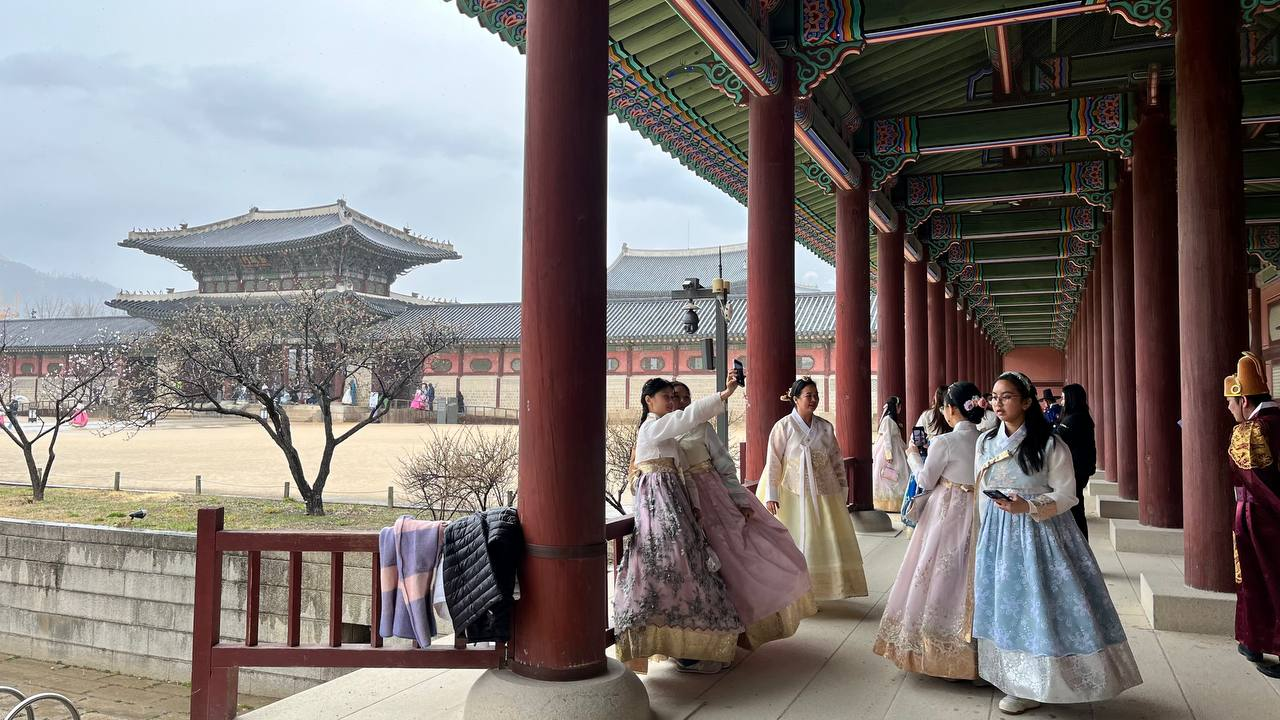

In [63]:
Image("/content/koree3.jpg")